In [14]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
%matplotlib inline

# Introduction to the Ad Click Through Rate Prediction Problem

Data from https://www.kaggle.com/c/avazu-ctr-prediction/data
    
11 days worth of Avazu data, ordered chronologically


24 features encompassing site attributes, application features, device attributes 

- id: ad identifier
- click: 0/1 for non-click/click
- hour: format is YYMMDDHH, so 14091123 means 23:00 on Sept. 11, 2014 UTC.
- C14 - C21 - Anonymized categorical variables. 
- Anonymous Site features - Site_id, Site_domain, Site_category
- Anonymous App features - app_id, app_domain 
- Anonymous Device features - device_type, device_conn_type 

In [2]:
#Code borrowed from https://github.com/rachit-mishra/Avazu-Click-Through-Rate-Prediction/blob/master/avazu_project.ipynb
#https://becominghuman.ai/predicting-click-probabilities-on-a-leading-advertising-platform-7582633e6e78

import pandas as pd
parse_date = lambda val : pd.datetime.strptime(val, '%y%m%d%H')
# Sampling the training data: Training data size == 5.87 gigabytes, Number of records === 40428966
# Using random sampling to select a sample of 1 million records 
import random
n = 40428966  #total number of records in the clickstream data 
sample_size = 1000000
skip_values = sorted(random.sample(range(1,n), n-sample_size))

train_data = pd.read_csv('train.gz', parse_dates = ['hour'], date_parser = parse_date, skiprows = skip_values,compression='gzip')
#X = pd.read_csv("adClickData.csv")
train_data.head()

,id,click,hour,C1,banner_pos,site_id,site_domain,site_category,app_id,app_domain,...,device_type,device_conn_type,C14,C15,C16,C17,C18,C19,C20,C21
0,10004510652136496837,0,2014-10-21,1005,0,543a539e,c7ca3108,3e814130,ecad2386,7801e8d9,...,1,0,20352,320,50,2333,0,39,-1,157
1,10006192453619779489,0,2014-10-21,1005,0,85f751fd,c4e18dd6,50e219e0,685d1c4c,2347f47a,...,1,3,15708,320,50,1722,0,35,-1,79
2,10010924186026106882,0,2014-10-21,1005,0,030440fe,08ba7db9,76b2941d,ecad2386,7801e8d9,...,1,0,18993,320,50,2161,0,35,-1,157
3,10012222478217629851,0,2014-10-21,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,...,1,0,15705,320,50,1722,0,35,100084,79
4,10014887683839786798,1,2014-10-21,1005,0,85f751fd,c4e18dd6,50e219e0,e2fcccd2,5c5a694b,...,1,0,4687,320,50,423,2,39,100148,32


In [3]:
import pandas as pd
import numpy as np

#visualization specific imports 
import matplotlib
import matplotlib.pyplot as plt
import seaborn
import sklearn
import matplotlib.dates as mdates

In [4]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000001 entries, 0 to 1000000
Data columns (total 24 columns):
id                  1000001 non-null uint64
click               1000001 non-null int64
hour                1000001 non-null datetime64[ns]
C1                  1000001 non-null int64
banner_pos          1000001 non-null int64
site_id             1000001 non-null object
site_domain         1000001 non-null object
site_category       1000001 non-null object
app_id              1000001 non-null object
app_domain          1000001 non-null object
app_category        1000001 non-null object
device_id           1000001 non-null object
device_ip           1000001 non-null object
device_model        1000001 non-null object
device_type         1000001 non-null int64
device_conn_type    1000001 non-null int64
C14                 1000001 non-null int64
C15                 1000001 non-null int64
C16                 1000001 non-null int64
C17                 1000001 non-null int64
C18     

Attributes have been allocated as 64-bit memory blocks when we actually don’t need that much space. We have been overutilizing a lot of space and that can be worked on to deal with the issue. A simple conversion of data types to int16 blocks for all the attributes helps us optimize the space utilization by 40%.

In [5]:
# Memory Optimization
data_types = {
    'id': np.str,
    'click': np.bool_,
    'hour': np.str,
    'C1': np.uint16,
    'banner_pos': np.uint16,
    'site_id': np.object,
    'site_domain': np.object,
    'site_category': np.object,
    'app_id': np.object,
    'app_domain': np.object,
    'app_category': np.object,
    'device_id': np.object,
    'device_ip': np.object,
    'device_model': np.object,
    'device_type': np.uint16,
    'device_conn_type': np.uint16,
    'C14': np.uint16,
    'C15': np.uint16,
    'C16': np.uint16,
    'C17': np.uint16,
    'C18': np.uint16,
    'C19': np.uint16,
    'C20': np.uint16,
    'C21': np.uint16
}
train_data = pd.read_csv('train.gz', parse_dates = ['hour'], date_parser = parse_date, 
                         skiprows = skip_values,compression='gzip',dtype = data_types)

In [6]:
train_data.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000001 entries, 0 to 1000000
Data columns (total 24 columns):
id                  1000001 non-null object
click               1000001 non-null bool
hour                1000001 non-null datetime64[ns]
C1                  1000001 non-null uint16
banner_pos          1000001 non-null uint16
site_id             1000001 non-null object
site_domain         1000001 non-null object
site_category       1000001 non-null object
app_id              1000001 non-null object
app_domain          1000001 non-null object
app_category        1000001 non-null object
device_id           1000001 non-null object
device_ip           1000001 non-null object
device_model        1000001 non-null object
device_type         1000001 non-null uint16
device_conn_type    1000001 non-null uint16
C14                 1000001 non-null uint16
C15                 1000001 non-null uint16
C16                 1000001 non-null uint16
C17                 1000001 non-null uint16
C

# Exploratory Data Analytics: Part 1

In [7]:
train_data.describe() 

,C1,banner_pos,device_type,device_conn_type,C14,C15,C16,C17,C18,C19,C20,C21
count,1.000001e+06,1.000001e+06,1.000001e+06,1.000001e+06,1.000001e+06,1.000001e+06,1.000001e+06,1.000001e+06,1.000001e+06,1.000001e+06,1.000001e+06,1.000001e+06
mean,1.004968e+03,2.884437e-01,1.015033e+00,3.312187e-01,1.883922e+04,3.188663e+02,6.010703e+01,2.111999e+03,1.432444e+00,2.275323e+02,4.908097e+04,8.340030e+01
std,1.092884e+00,5.050110e-01,5.260922e-01,8.552737e-01,4.965915e+03,2.104799e+01,4.729254e+01,6.103284e+02,1.326109e+00,3.512351e+02,1.544858e+04,7.030315e+01
min,1.001000e+03,0.000000e+00,0.000000e+00,0.000000e+00,3.750000e+02,1.200000e+02,2.000000e+01,1.120000e+02,0.000000e+00,3.300000e+01,3.446400e+04,1.000000e+00
25%,1.005000e+03,0.000000e+00,1.000000e+00,0.000000e+00,1.692000e+04,3.200000e+02,5.000000e+01,1.863000e+03,0.000000e+00,3.500000e+01,3.454800e+04,2.300000e+01
50%,1.005000e+03,0.000000e+00,1.000000e+00,0.000000e+00,2.034600e+04,3.200000e+02,5.000000e+01,2.323000e+03,2.000000e+00,3.900000e+01,3.465700e+04,6.100000e+01
75%,1.005000e+03,1.000000e+00,1.000000e+00,0.000000e+00,2.189400e+04,3.200000e+02,5.000000e+01,2.526000e+03,3.000000e+00,1.710000e+02,6.553500e+04,1.010000e+02
max,1.012000e+03,7.000000e+00,5.000000e+00,5.000000e+00,2.405200e+04,1.024000e+03,1.024000e+03,2.758000e+03,3.000000e+00,1.839000e+03,6.553500e+04,2.550000e+02


In [8]:
train_data.head()

,id,click,hour,C1,banner_pos,site_id,site_domain,site_category,app_id,app_domain,...,device_type,device_conn_type,C14,C15,C16,C17,C18,C19,C20,C21
0,10004510652136496837,False,2014-10-21,1005,0,543a539e,c7ca3108,3e814130,ecad2386,7801e8d9,...,1,0,20352,320,50,2333,0,39,65535,157
1,10006192453619779489,False,2014-10-21,1005,0,85f751fd,c4e18dd6,50e219e0,685d1c4c,2347f47a,...,1,3,15708,320,50,1722,0,35,65535,79
2,10010924186026106882,False,2014-10-21,1005,0,030440fe,08ba7db9,76b2941d,ecad2386,7801e8d9,...,1,0,18993,320,50,2161,0,35,65535,157
3,10012222478217629851,False,2014-10-21,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,...,1,0,15705,320,50,1722,0,35,34548,79
4,10014887683839786798,True,2014-10-21,1005,0,85f751fd,c4e18dd6,50e219e0,e2fcccd2,5c5a694b,...,1,0,4687,320,50,423,2,39,34612,32


### CTR analysis ~ Click v/s No click distribution

False    0.830171
True     0.169829
Name: click, dtype: float64


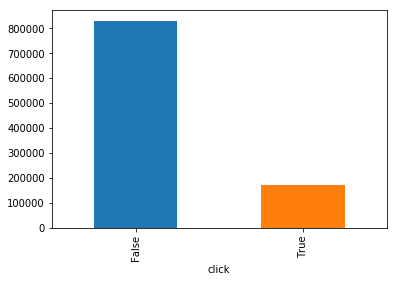

In [9]:
%matplotlib inline

train_data.groupby('click').size().plot(kind = 'bar')
rows = train_data.shape[0]
click_through_rate = train_data['click'].value_counts()/rows 
print(click_through_rate)

### Click through rate on a set of 1 million records of click stream data sampled at random from the population of 40 million records is 17%.


## Feature Engineering 

### Studying the relationships between different features and the target variable i.e 'Click'. Manipulating data in the process, introducing new metrics

### HOUR 

count                 1000001
unique                    240
top       2014-10-22 09:00:00
freq                    11267
first     2014-10-21 00:00:00
last      2014-10-30 23:00:00
Name: hour, dtype: object

,click
hour,
2014-10-21 00:00:00,2969
2014-10-21 01:00:00,3464
2014-10-21 02:00:00,5080
2014-10-21 03:00:00,4765
2014-10-21 04:00:00,6409


,click
hour,
2014-10-22 09:00:00,11267
2014-10-22 10:00:00,10763
2014-10-22 11:00:00,9679
2014-10-22 12:00:00,9928
2014-10-28 13:00:00,10633
2014-10-28 14:00:00,9573


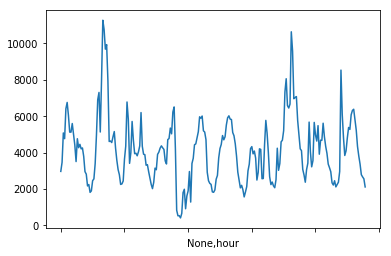

In [17]:
#Metric 1. HOUR 
train_data.hour.describe() 

#plot the number of impresessions for every hour
df_impressions = train_data.groupby('hour').agg({'click':'count'})
df_impressions.head()
df_impressions.loc[df_impressions['click']>9000]
df_impressions.unstack().plot()
plt.show()

,click
hour,
2014-10-21 00:00:00,513.0
2014-10-21 01:00:00,591.0
2014-10-21 02:00:00,778.0
2014-10-21 03:00:00,836.0
2014-10-21 04:00:00,980.0


,click
hour,
2014-10-22 09:00:00,1608.0
2014-10-22 10:00:00,1506.0
2014-10-22 11:00:00,1304.0
2014-10-22 12:00:00,1317.0
2014-10-28 13:00:00,1452.0
2014-10-28 14:00:00,1400.0


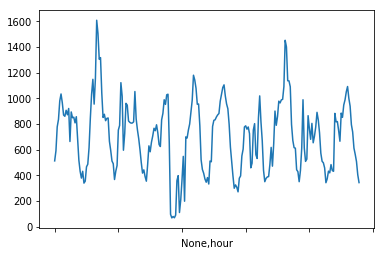

In [19]:
#plot the number of clicks for every hour
df_click = train_data[train_data['click']==1]
temp_click = df_click.groupby('hour').agg({'click' : 'sum'})
temp_click.head()
temp_click.loc[temp_click['click']>1300]
temp_click.unstack().plot()


Note that for 2 hours each on 22nd and 28th Oct, there was a large number of impressions as well as clicks.

# Creating Metrics From The Hour Field 

In [20]:
''' HOUR as a metric is difficult to read because it is a time stamp 
    Introducing new metrics: 
     1. hour_in_day
     2. weekday -- To study user behavior w.r.t clicks on each day 
     3. Day_name -- To extract the day name from the HOUR feature for a better understanding 
'''

train_data['hour_in_day'] = train_data['hour'].apply(lambda val : val.hour)
train_data['weekday'] = train_data['hour'].apply(lambda val: val.dayofweek)
train_data['day_name'] = train_data['hour'].apply(lambda x: x.strftime('%A'))
train_data_clicks = train_data[train_data['click']==1]


' HOUR as a metric is difficult to read because it is a time stamp \n    Introducing new metrics: \n     1. hour_in_day\n     2. weekday -- To study user behavior w.r.t clicks on each day \n     3. Day_name -- To extract the day name from the HOUR feature for a better understanding \n'

In [21]:
train_data.columns

Index(['id', 'click', 'hour', 'C1', 'banner_pos', 'site_id', 'site_domain',
       'site_category', 'app_id', 'app_domain', 'app_category', 'device_id',
       'device_ip', 'device_model', 'device_type', 'device_conn_type', 'C14',
       'C15', 'C16', 'C17', 'C18', 'C19', 'C20', 'C21', 'hour_in_day',
       'weekday', 'day_name'],
      dtype='object')

# HOUR IN DAY

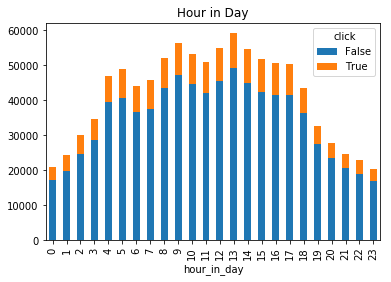

In [22]:
#train_data['hour_in_day'].nunique() ~ 0 TO 23 
train_data.groupby(['hour_in_day', 'click']).size().unstack().plot(kind='bar', stacked=True, title="Hour in Day")

Insight: Most impressions happen at 1pm!

In [23]:
train_data[['hour_in_day','click']].groupby(['hour_in_day']).sum().sort_values('click',ascending=False)

,click
hour_in_day,
13,9993.0
14,9611.0
15,9270.0
12,9227.0
9,9083.0
16,9025.0
10,8724.0
17,8718.0
11,8677.0


Not just impressions, even most clicks happen at 1pm!

## Hour in day - CTR v/s impressions analysis 

In [24]:
hour_df = pd.DataFrame()

In [25]:
hour_df['hr'] = train_data_clicks[['hour_in_day','click']].groupby(['hour_in_day']).count().reset_index().sort_values('click',ascending=False)['hour_in_day']
hour_df['pos_clicks'] = train_data_clicks[['hour_in_day','click']].groupby(['hour_in_day']).count().reset_index().sort_values('click',ascending=False)['click']
hour_df['impressions_total'] = train_data[['hour_in_day','click']].groupby(['hour_in_day']).count().reset_index().sort_values('click',ascending=False)['click']
hour_df['click_through_rate'] = 100*hour_df['pos_clicks']/hour_df['impressions_total']
hour_df.sort_values(ascending = False, by = 'click_through_rate')

,hr,pos_clicks,impressions_total,click_through_rate
1,1,4535,24347,18.626525
0,0,3832,20926,18.312148
15,15,9270,51626,17.956069
16,16,9025,50479,17.878722
2,2,5334,30050,17.750416
7,7,8085,45597,17.731430
14,14,9611,54439,17.654623
17,17,8718,50300,17.332008
3,3,5986,34621,17.290084
11,11,8677,50733,17.103266


In [26]:
list_of_hours = hour_df.sort_values(by='click_through_rate',ascending=False)['hr'].tolist()

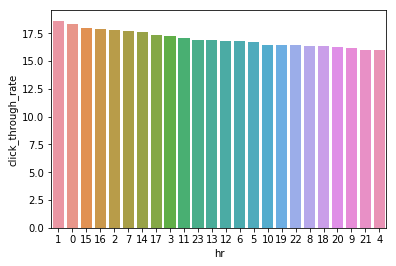

In [27]:
import seaborn as sns
sns.barplot(y='click_through_rate',x='hr'\
            ,data=hour_df\
            ,order=list_of_hours)

This shows that hour of the day could be a good feature to predict CTR.

# Weekday ~ day_name (for impressions)

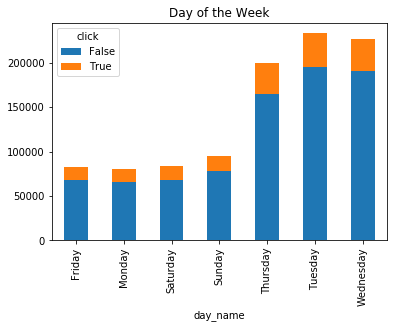

In [28]:
train_data.groupby(['day_name','click']).size().unstack().plot(kind='bar', stacked=True, title="Day of the Week")

# weekday ~ day_name (for clicks)

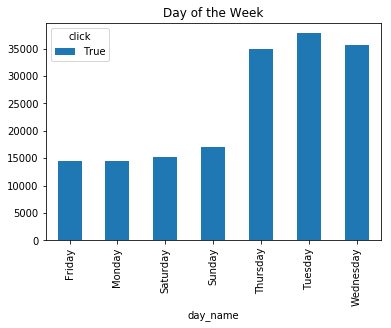

In [29]:
train_data_clicks.groupby(['day_name','click']).size().unstack().plot(kind='bar', stacked=True, title="Day of the Week")

In [30]:
train_data_clicks[['day_name','click']].groupby(['day_name']).count().sort_values('click',ascending=False)

,click
day_name,
Tuesday,37802
Wednesday,35643
Thursday,35001
Sunday,17133
Saturday,15216
Monday,14537
Friday,14497


### Most clicks on Tuesday, then wednesday followed by Thursday

# Day wise analysis of click through rates 

In [31]:
day_df = pd.DataFrame()

In [32]:
day_df['day'] = train_data_clicks[['day_name','click']].groupby(['day_name']).count()\
        .reset_index().sort_values('click',ascending=False)['day_name']
day_df['pos_clicks'] = train_data_clicks[['day_name','click']].groupby(['day_name']).count()\
        .reset_index().sort_values('click',ascending=False)['click']
day_df['total_impressions'] = train_data[['day_name','click']].groupby(['day_name']).count()\
        .reset_index().sort_values('click',ascending=False)['click']
day_df['click_pct'] = 100*day_df['pos_clicks']/day_df['total_impressions']
day_df.sort_values(ascending = False, by = 'click_pct')

,day,pos_clicks,total_impressions,click_pct
2,Saturday,15216,83143,18.300999
1,Monday,14537,79837,18.208350
3,Sunday,17133,95031,18.028854
0,Friday,14497,82294,17.616108
4,Thursday,35001,200047,17.496388
5,Tuesday,37802,232999,16.224104
6,Wednesday,35643,226650,15.726009


### Saturday has the highest value of click through rate 

In [33]:
list_of_days = day_df.sort_values(by='click_pct',ascending=False)['day'].tolist()

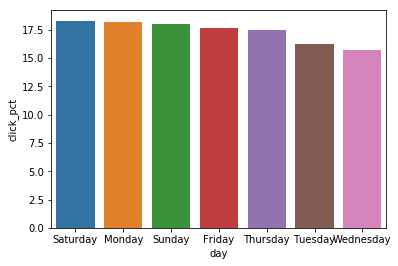

In [34]:
sns.barplot(y='click_pct',x='day'\
            ,data=day_df\
            ,order=list_of_days)

# Exploratory Data Analytics: Part 2
# Banner Position

### Banner positions representing attractive and appealing designs that might highly affect a user's behavior and in turn trigger their decision to click. Or not. Hence making it an effective metric to predict clicks

In [35]:
train_data['banner_pos'].unique()

array([0, 1, 5, 2, 7, 4, 3], dtype=uint64)

#### It's unclear as to what the 7 banner positions (represented as integers) represent. Intuitively and based on research, the 7 positions might represent ad placing in a 2D webpage  

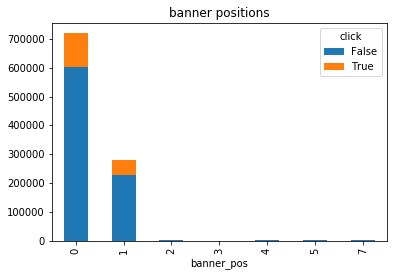

In [36]:
banner_temp =train_data[['banner_pos','click']].groupby(['banner_pos','click'])
banner_temp.size().unstack().plot(kind='bar',stacked=True, title='banner positions')

#### Positions 0 and 1 ~ the most prominent banner positions garnering most impressions 

In [37]:
train_data[['banner_pos','click']].groupby(['banner_pos']).count().sort_values('click',ascending=False)

,click
banner_pos,
0,719344
1,278925
7,1047
2,315
4,182
5,134
3,54


### BANNER POSITIONS 0 and 1 generate most impressions and clicks

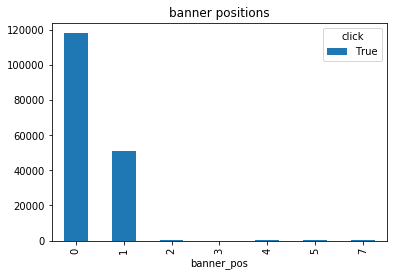

In [38]:
banner_temp =train_data_clicks[['banner_pos','click']].groupby(['banner_pos','click'])
banner_temp.size().unstack().plot(kind='bar',stacked=True, title='banner positions')

In [39]:
train_data_clicks[['banner_pos','click']].groupby(['banner_pos']).count().sort_values('click',ascending=False)

,click
banner_pos,
0,118193
1,51194
7,358
2,28
4,25
5,24
3,7


## CTR analysis on Banner position 


In [41]:
import pandas as pd 
banner_df = pd.DataFrame()
banner_df['position'] = train_data_clicks[['banner_pos','click']].groupby(['banner_pos']).count()\
    .reset_index().sort_values('click',ascending=False)['banner_pos']
banner_df['pos_clicks'] = train_data_clicks[['banner_pos','click']].groupby(['banner_pos']).count()\
    .reset_index().sort_values('click',ascending=False)['click']
banner_df['total_impressions'] = train_data[['banner_pos','click']].groupby(['banner_pos']).count()\
    .reset_index().sort_values('click',ascending=False)['click']
banner_df['click_pct'] = 100*banner_df['pos_clicks']/banner_df['total_impressions']
banner_df.sort_values(ascending=False,by='click_pct')

,position,pos_clicks,total_impressions,click_pct
6,7,358,1047,34.192932
1,1,51194,278925,18.354038
5,5,24,134,17.910448
0,0,118193,719344,16.430665
4,4,25,182,13.736264
3,3,7,54,12.962963
2,2,28,315,8.888889


#### Banner position 7 has the highest click through rate 

In [42]:
list_of_banners = banner_df.sort_values(by='click_pct',ascending=False)['position'].tolist()

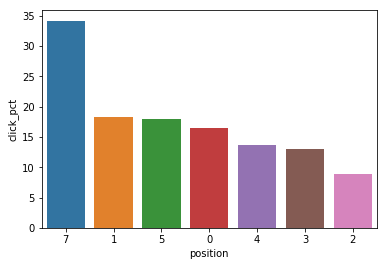

In [43]:
sns.barplot(y='click_pct',x='position'\
            ,data=banner_df\
            ,order=list_of_banners)

#### Banner position 7 seems to be a nice choice for placing advertisements. As per click through rate. 

# DEVICE TYPE Metrics

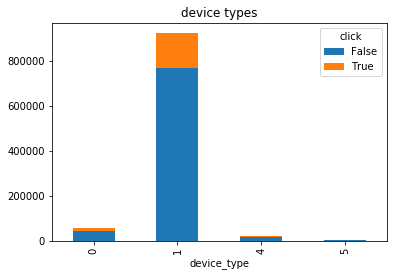

In [44]:
device_temp = train_data[['device_type','click']].groupby(['device_type','click'])
device_temp.size().unstack().plot(kind='bar',stacked=True, title='device types')

### Device type 1 getting most impressions among the 4 devices

In [45]:
train_data[['device_type','click']].groupby(['device_type']).count().sort_values('click',ascending=False)

,click
device_type,
1,922945
0,54822
4,19081
5,3153


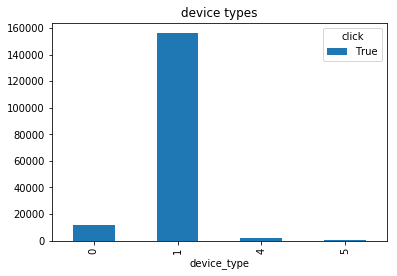

In [46]:
train_data_clicks[['device_type','click']].groupby(['device_type','click']).size().unstack().plot(kind='bar',stacked=True, title='device types')

In [47]:
train_data_clicks[['device_type','click']].groupby(['device_type']).count().sort_values('click',ascending=False)

,click
device_type,
1,156104
0,11538
4,1907
5,280


### Device Type 1 gets the maximum number of clicks too

In [48]:
# extract CLICKS for DEVICE TYPE 1 
device1_df = train_data_clicks[train_data_clicks['device_type']==1]

### Hourly distribution of clicks on Device 1

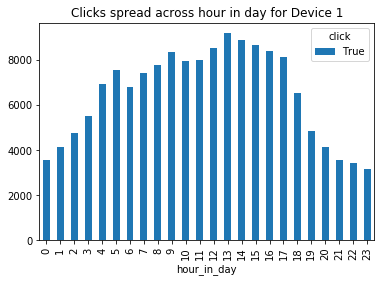

In [49]:
temp_device_df = device1_df.groupby(['hour_in_day', 'click'])
temp_device_df.size().unstack().plot(kind='bar', stacked=True, title="Clicks spread across hour in day for Device 1")

#### Device type 1 --- probably cell phone/Desktop 

Reasons --- Businesses might not prefer showing ads later in the evening----- after work hours// business hours ( Click spread max between 9 to 5 ) 



## Click through rate analysis w.r.t Device type


In [50]:
import pandas as pd
dev_type_df=pd.DataFrame()
dev_type_df_total_imp = pd.DataFrame()
dev_type_df = train_data_clicks.groupby('device_type').agg({'click':'sum'}).reset_index()
dev_type_df['total_impressions'] = train_data.groupby('device_type').agg({'click':'count'}).reset_index()['click']
dev_type_df['success_pct'] = (dev_type_df['click']/dev_type_df['total_impressions'])*100
dev_type_df.sort_values(ascending=False,by='success_pct')

,device_type,click,total_impressions,success_pct
0,0,11538.0,54822,21.046295
1,1,156104.0,922945,16.913684
2,4,1907.0,19081,9.994235
3,5,280.0,3153,8.880431


### Device Type 0 with the highest click through rate

## App Related Metrics

#### App_Id, App_Domain, App_Category

In [51]:
app_features = ['app_id', 'app_domain', 'app_category']

In [52]:
train_data.groupby('app_category').agg({'click':'sum'}).sort_values(by='click',ascending = False)


,click
app_category,
07d7df22,128908.0
0f2161f8,25539.0
f95efa07,6948.0
cef3e649,4066.0
8ded1f7a,3291.0
d1327cf5,368.0
dc97ec06,203.0
09481d60,203.0
75d80bbe,96.0


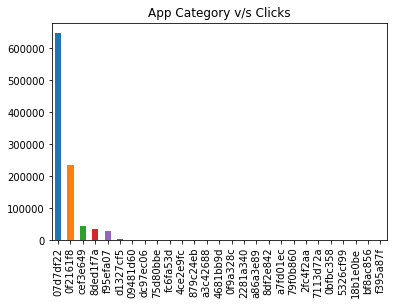

In [53]:
train_data['app_category'].value_counts().plot(kind='bar', title='App Category v/s Clicks')


### Studying Clicks behavior across different app categories

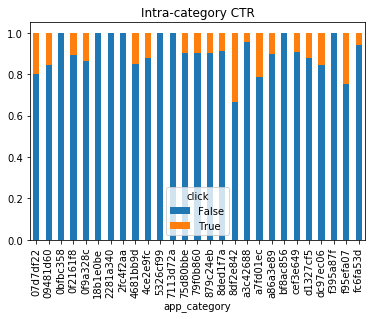

In [54]:
train_app_category = train_data.groupby(['app_category', 'click']).size().unstack()
train_app_category.div(train_app_category.sum(axis=1), axis=0).plot(kind='bar', stacked=True, title="Intra-category CTR")

# Developing Logistic Regression Prediction model

### Using the key metrics discussed above as a part of the EDA to put together a predictive model in order to forecast the possibility of a click

### Data preparation stage ~~ To be fed in the data pipeline 

In [55]:
model_features = ['weekday', 'hour_in_day','banner_pos', 'site_category',
                  'device_conn_type', 'app_category','device_type']
model_target = 'click'

In [56]:
#### Clubbing the model features with the target and selecting a fraction in order to speeden up computation
train_model = train_data[model_features+[model_target]].sample(frac=0.1,random_state=42)

In [57]:
#### Features Site_category and App_category are hashed and need to be represented in a readable format
#### Banner_pos is represented as integers hence we make use of one hot encoding to deal with all these features
train_model = pd.get_dummies(train_model,columns=['site_category','app_category','banner_pos'],sparse = True)

In [58]:
train_model.head()

,weekday,hour_in_day,device_conn_type,device_type,click,site_category_0569f928,site_category_28905ebd,site_category_335d28a8,site_category_3e814130,site_category_42a36e14,...,app_category_dc97ec06,app_category_f95efa07,app_category_fc6fa53d,banner_pos_0,banner_pos_1,banner_pos_2,banner_pos_3,banner_pos_4,banner_pos_5,banner_pos_7
624589,0,10,3,1,False,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
79954,1,16,2,1,True,0,1,0,0,0,...,0,0,0,1,0,0,0,0,0,0
567130,6,16,0,1,False,0,1,0,0,0,...,0,0,0,1,0,0,0,0,0,0
500891,6,2,0,1,False,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
55399,1,10,0,1,False,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0


### Extracting all columns from the train model except the target mask column 

In [59]:
model_features = np.array(train_model.columns[train_model.columns!=model_target].tolist())

In [60]:
from sklearn.model_selection import train_test_split

In [61]:
#from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(
    train_model[model_features].values,
    train_model[model_target].values,
    test_size=0.3,
    random_state=42
)


### Feature Selection ~ To reduce the dimensional space occupied and to deal with overfitting, use GRID SEARCH cross validation and regularization to obtain trade off b/w number of features and F-1 score

In [62]:
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV

from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import f1_score


### F1 score used as a performance metric because it represents the harmonic mean between precision and recall 

In [63]:
num_splits = 3
c_values = np.logspace(-3,0,7)


In [55]:
stratified_k_fold = StratifiedKFold(n_splits=num_splits)

scores = np.zeros(7)
nr_params = np.zeros(7)


### Model: logistic Regression with L1 regularization and balanced class weights

In [56]:
for train_data, valid_data in stratified_k_fold.split(x_train,y_train):
    for i, c in enumerate(np.logspace(-3, 0, 7)):
        lr_classify = LogisticRegression(penalty='l1',class_weight='balanced',C = c)
        lr_classify.fit(x_train[train_data],y_train[train_data])
        #validation_Set evaluation
        y_prediction = lr_classify.predict(x_train[valid_data])
        score_f1 = f1_score(y_train[valid_data],y_prediction, average='weighted' )
        scores[i] += score_f1 / num_splits
        model_selected = SelectFromModel(lr_classify, prefit=True)
        #get_support([indices]): Get a mask, or integer index, of the features selected
        nr_params[i] += np.sum(model_selected.get_support()) / num_splits

LogisticRegression(C=0.001, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l1', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

LogisticRegression(C=0.0031622776601683794, class_weight='balanced',
          dual=False, fit_intercept=True, intercept_scaling=1,
          max_iter=100, multi_class='ovr', n_jobs=1, penalty='l1',
          random_state=None, solver='liblinear', tol=0.0001, verbose=0,
          warm_start=False)

LogisticRegression(C=0.01, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l1', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

LogisticRegression(C=0.03162277660168379, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l1', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

LogisticRegression(C=0.1, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l1', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

LogisticRegression(C=0.31622776601683794, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l1', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

LogisticRegression(C=1.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l1', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

LogisticRegression(C=0.001, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l1', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

LogisticRegression(C=0.0031622776601683794, class_weight='balanced',
          dual=False, fit_intercept=True, intercept_scaling=1,
          max_iter=100, multi_class='ovr', n_jobs=1, penalty='l1',
          random_state=None, solver='liblinear', tol=0.0001, verbose=0,
          warm_start=False)

LogisticRegression(C=0.01, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l1', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

LogisticRegression(C=0.03162277660168379, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l1', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

LogisticRegression(C=0.1, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l1', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

LogisticRegression(C=0.31622776601683794, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l1', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

LogisticRegression(C=1.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l1', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

LogisticRegression(C=0.001, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l1', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

LogisticRegression(C=0.0031622776601683794, class_weight='balanced',
          dual=False, fit_intercept=True, intercept_scaling=1,
          max_iter=100, multi_class='ovr', n_jobs=1, penalty='l1',
          random_state=None, solver='liblinear', tol=0.0001, verbose=0,
          warm_start=False)

LogisticRegression(C=0.01, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l1', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

LogisticRegression(C=0.03162277660168379, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l1', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

LogisticRegression(C=0.1, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l1', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

LogisticRegression(C=0.31622776601683794, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l1', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

LogisticRegression(C=1.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l1', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

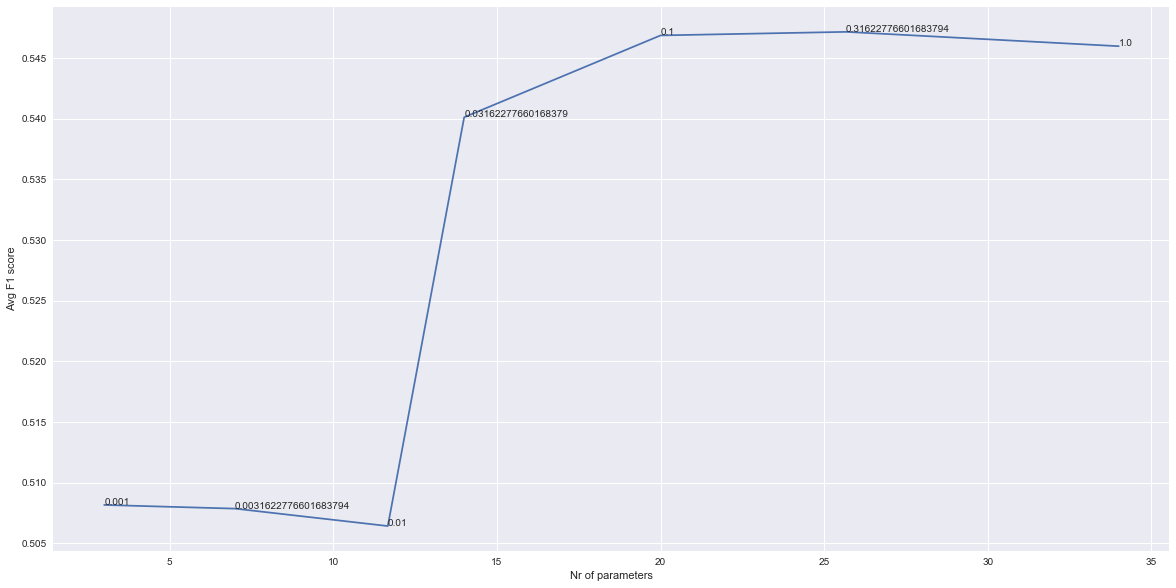

In [57]:
plt.figure(figsize=(20, 10))
plt.plot(nr_params, scores)

for i, c in enumerate(c_values):
    plt.annotate(c, (nr_params[i], scores[i]))
plt.xlabel("Nr of parameters")
plt.ylabel("Avg F1 score")


### Parameters obtained using c = 0.1 manage to reduce parameters dimension which optimizes the execution time also improving generalization capacity. 


In [58]:
lr_classify = LogisticRegression(C=0.1, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l1', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)


In [75]:
lr_classify.fit(x_train, y_train)
y_pred = lr_classify.predict(x_test)
predictions = [round(value) for value in y_pred]
print(metrics.accuracy_score(y_test, predictions))
print(metrics.confusion_matrix(y_test, predictions))
print(metrics.roc_auc_score(y_test, predictions))

LogisticRegression(C=0.1, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l1', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

0.5004666666666666
[[11273 13605]
 [ 1381  3741]]
0.591755019473555


In [60]:
model_selected = SelectFromModel(lr_classify,prefit=True )

In [61]:
pruned_params = model_selected.get_support()
pruned_params

array([ True,  True,  True,  True, False,  True,  True,  True, False,
        True, False,  True,  True,  True, False, False, False, False,
        True, False, False,  True,  True, False, False, False, False,
       False, False, False, False, False, False, False,  True, False,
       False, False, False,  True,  True, False,  True, False,  True,
        True, False, False, False, False,  True])

In [62]:
model_features = model_features[pruned_params]
x_train = x_train[:, pruned_params]
x_test = x_test[:, pruned_params]

# Developing Gradient Boosting Prediction Model

In [63]:
import xgboost
from xgboost import XGBClassifier
from sklearn.metrics import classification_report

In [64]:
x_train, x_valid, y_train, y_valid = train_test_split(x_train,y_train,stratify=y_train,test_size=0.1,random_state=42)

In [65]:
model = XGBClassifier()
xgb_clf = model

In [76]:
xgb_clf.fit(x_train, y_train, early_stopping_rounds=10,eval_metric="logloss", eval_set=[(x_valid, y_valid)], verbose=False)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [77]:
y_pred = xgb_clf.predict(x_test)
predictions = [round(value) for value in y_pred]

C:\Users\gmanish\AppData\Local\Continuum\Anaconda\envs\py36\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [78]:
from sklearn import metrics
print(metrics.accuracy_score(y_test, predictions))

0.8293333333333334


### The model has an 83% accuracy score.

## Saving the XGBoost and Logistic models

In [79]:
import pickle
filename = 'xgb_mod.sav'
filename2 = 'logistic.sav'
pickle.dump(xgb_clf,open(filename, 'wb' ))
pickle.dump(lr_classify, open(filename2, 'wb'))
